In [1]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os,sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from skimage import util 
from skimage.transform import resize
from scipy.misc import imresize
from skimage.io import imread
import warnings
from numpy import inf

from scipy.stats import kurtosis,skew

plt.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings("ignore")
import gc
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation
%load_ext jupyternotify

from scipy.stats import chi2_contingency
from sklearn.metrics import mutual_info_score
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage import feature
from scipy import stats
# Def: Read STL 10 images
def read_STL10_data():
    # read all of the data (STL 10) https://github.com/mttk/STL10
    def read_all_images(path_to_data):
        """
        :param path_to_data: the file containing the binary images from the STL-10 dataset
        :return: an array containing all the images
        """

        with open(path_to_data, 'rb') as f:
            # read whole file in uint8 chunks
            everything = np.fromfile(f, dtype=np.uint8)

            # We force the data into 3x96x96 chunks, since the
            # images are stored in "column-major order", meaning
            # that "the first 96*96 values are the red channel,
            # the next 96*96 are green, and the last are blue."
            # The -1 is since the size of the pictures depends
            # on the input file, and this way numpy determines
            # the size on its own.

            images = np.reshape(everything, (-1, 3, 96, 96))

            # Now transpose the images into a standard image format
            # readable by, for example, matplotlib.imshow
            # You might want to comment this line or reverse the shuffle
            # if you will use a learning algorithm like CNN, since they like
            # their channels separated.
            images = np.transpose(images, (0, 3, 2, 1))
            return images
    def read_labels(path_to_labels):
        """
        :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
        :return: an array containing the labels
        """
        with open(path_to_labels, 'rb') as f:
            labels = np.fromfile(f, dtype=np.uint8)
            return labels
    def show_images(data,row=1,col=1):
        fig=plt.figure(figsize=(10,10))
        columns = col; rows = row
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            plt.imshow(data[i-1])
        plt.show()

    train_images = read_all_images("../../../../DataSet/STL10/stl10_binary/train_X.bin") / 255.0
    train_labels = read_labels    ("../../../../DataSet/STL10/stl10_binary/train_Y.bin")
    test_images  = read_all_images("../../../../DataSet/STL10/stl10_binary/test_X.bin")  / 255.0
    test_labels  = read_labels    ("../../../../DataSet/STL10/stl10_binary/test_y.bin")

    label_encoder= OneHotEncoder(sparse=False,categories='auto')
    train_labels = label_encoder.fit_transform(train_labels.reshape((-1,1)))
    test_labels  = label_encoder.fit_transform(test_labels.reshape((-1,1)))

    print(train_images.shape,train_images.max(),train_images.min())
    print(train_labels.shape,train_labels.max(),train_labels.min())
    print(test_images.shape,test_images.max(),test_images.min())
    print(test_labels.shape,test_labels.max(),test_labels.min())
    return train_images,train_labels,test_images,test_labels
# Def: Read CIFAR 10 images
def read_CIFAR10_data():
    # ====== miscellaneous =====
    # code from: https://github.com/tensorflow/tensorflow/issues/8246
    def tf_repeat(tensor, repeats):
        """
        Args:

        input: A Tensor. 1-D or higher.
        repeats: A list. Number of repeat for each dimension, length must be the same as the number of dimensions in input

        Returns:

        A Tensor. Has the same type as input. Has the shape of tensor.shape * repeats
        """
        expanded_tensor = tf.expand_dims(tensor, -1)
        multiples = [1] + repeats
        tiled_tensor = tf.tile(expanded_tensor, multiples = multiples)
        repeated_tesnor = tf.reshape(tiled_tensor, tf.shape(tensor) * repeats)
        return repeated_tesnor
    def unpickle(file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    # ====== miscellaneous =====

    # data
    PathDicom = "../../Dataset/cifar-10-batches-py/"
    lstFilesDCM = []  # create an empty list
    for dirName, subdirList, fileList in os.walk(PathDicom):
        for filename in fileList:
            if not ".html" in filename.lower() and not  ".meta" in filename.lower():  # check whether the file's DICOM
                lstFilesDCM.append(os.path.join(dirName,filename))

    # Read the data traind and Test
    batch0 = unpickle(lstFilesDCM[0])
    batch1 = unpickle(lstFilesDCM[1])
    batch2 = unpickle(lstFilesDCM[2])
    batch3 = unpickle(lstFilesDCM[3])
    batch4 = unpickle(lstFilesDCM[4])

    onehot_encoder = OneHotEncoder(sparse=True)
    train_batch = np.vstack((batch0[b'data'],batch1[b'data'],batch2[b'data'],batch3[b'data'],batch4[b'data']))
    train_label = np.expand_dims(np.hstack((batch0[b'labels'],batch1[b'labels'],batch2[b'labels'],batch3[b'labels'],batch4[b'labels'])).T,axis=1).astype(np.float64)
    train_label = onehot_encoder.fit_transform(train_label).toarray().astype(np.float64)

    test_batch = unpickle(lstFilesDCM[5])[b'data']
    test_label = np.expand_dims(np.array(unpickle(lstFilesDCM[5])[b'labels']),axis=0).T.astype(np.float64)
    test_label = onehot_encoder.fit_transform(test_label).toarray().astype(np.float64)

    # reshape data
    train_batch = np.reshape(train_batch,(len(train_batch),3,32,32)); test_batch = np.reshape(test_batch,(len(test_batch),3,32,32))
    # rotate data
    train_batch = np.rot90(np.rot90(train_batch,1,axes=(1,3)),3,axes=(1,2)).astype(np.float64); test_batch = np.rot90(np.rot90(test_batch,1,axes=(1,3)),3,axes=(1,2)).astype(np.float64)
    # normalize
    train_batch= train_batch/255.0; test_batch = test_batch/255.0

    # print out the data shape and the max and min value
    print(train_batch.shape,train_batch.max(),train_batch.min())
    print(train_label.shape,train_label.max(),train_label.min())
    print(test_batch.shape,test_batch.max(),test_batch.min())
    print(test_label.shape,test_label.max(),test_label.min())
    return train_batch,train_label,test_batch,test_label

<IPython.core.display.Javascript object>

In [51]:
# create the layers
def tf_softmax(x):    return tf.nn.softmax(x)
def tf_elu(x):       return tf.nn.elu(x)
def tf_relu(x):       return tf.nn.relu(x)
def tf_iden(x):       return x
def tf_sigmoid(x):    return tf.nn.sigmoid(x)
def tf_tanh(x):    return tf.nn.tanh(x)
def tf_atan(x): return tf.atan(x)
def tf_softplus(x):   return tf.nn.softplus(x)

class CNN():

    def __init__(self,k,inc,out, stddev=0.05,act=tf_elu):
        self.w              = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.act = act

    def getw(self): return self.w
    
    # Feed Forward for two variables
    def feedforward(self,input,stride=1,padding='VALID'):
        self.input1  = input
        self.layer1  = tf.nn.conv2d(self.input1,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA1 = self.act(self.layer1)
        return self.layer1, self.layerA1
    def feedforward2(self,input,stride=1,padding='VALID'):
        self.input2  = input
        self.layer2  = tf.nn.conv2d(self.input2,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA2 = self.act(self.layer2)
        return self.layer2, self.layerA2
class tf_instance_norm_layer():
    
    def __init__(self,batch_size,vector_shape):
        self.moving_mean = tf.Variable(tf.zeros(shape=[batch_size,1,1,vector_shape],dtype=tf.float64))
        self.moving_vari = tf.Variable(tf.zeros(shape=[batch_size,1,1,vector_shape],dtype=tf.float64))
        self.axis        = (1,2)
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
def calc_MI(x, y, bins=(90*90)/4):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi
def softmax_multi(target, axis=(1,2), name=None):
    max_axis   = tf.reduce_max(target, axis, keepdims=True)
    target_exp = tf.exp(target-max_axis)
    normalize  = tf.reduce_sum(target_exp, axis, keepdims=True)
    softmax    = target_exp / normalize
    return softmax

In [12]:
# read the data
train_images,train_labels,test_images,test_labels = read_STL10_data()
train_images = train_images.mean(3,keepdims=True)
train_images = (train_images-train_images.min((0,1,2),keepdims=True))/(train_images.max((0,1,2),keepdims=True)-train_images.min((0,1,2),keepdims=True)+1e-8)
# 1. sym padding 
# 2. sug metn sim -> not a good idea (sparse filtering - population sparsity -)
# 3. sales pitch - data aug (latent space) (paper - how is different from x)
# 4. baseline - other approaches - 
# 5. show negative images 
# 6. sparse filtering
# 7. classifier - mmke it a dense

(5000, 96, 96, 3) 1.0 0.0
(5000, 10) 1.0 0.0
(8000, 96, 96, 3) 1.0 0.0
(8000, 10) 1.0 0.0


In [13]:
# hyeper
num_eps   = 1; num_epoch = 10; learning_rate = 0.0001; batch_size = 20;  alpha = 0.5
beta1,beta2,adam_e  = 0.9,0.999,1e-8; 

In [132]:
# create layers
num_of_aug  = 6
l1_encoder  = CNN(3,1,num_of_aug,           act=tf_elu)
l2_encoder  = CNN(1,  num_of_aug,num_of_aug,act=tf_elu)
l3_encoder  = CNN(3,  num_of_aug,num_of_aug,act=tf_elu)
l4_encoder  = CNN(1,  num_of_aug,num_of_aug,act=tf_elu)
l5_encoder  = CNN(3,  num_of_aug,num_of_aug,act=tf_elu)
l6_encoder  = CNN(1,  num_of_aug,num_of_aug,act=tf_sigmoid)

l1_with_image = CNN(3,num_of_aug*2,num_of_aug*2,act=tf_elu)
l2_with_image = CNN(3,num_of_aug*2,num_of_aug*2,act=tf_elu)
l3_with_image = CNN(3,num_of_aug*2,1,act=tf_iden)

def with_image(input_data):
    _,layer1_g = l1_with_image.feedforward(input_data)
    _,layer2_g = l1_with_image.feedforward(layer1_g)
    _,layer3_g = l1_with_image.feedforward(layer2_g)
    return layer3_g
def with_noise(inpud_data):
    _,l1_noise = l1_with_noise.feedforward(inpud_data)
    _,l2_noise = l2_with_noise.feedforward(l1_noise)
    _,l3_noise = l3_with_noise.feedforward(l2_noise)
    return l3_noise

x_encoding = tf.placeholder(tf.float32,(None,96,96,1))
x_reisze   = tf.image.resize_images(x_encoding,(90,90))
x_reisze   = tf.tile(x_reisze,(1,1,1,num_of_aug))

_,layer1_e = l1_encoder.feedforward(x_encoding)
_,layer2_e = l2_encoder.feedforward(layer1_e)
_,layer3_e = l3_encoder.feedforward(layer2_e)
_,layer4_e = l4_encoder.feedforward(layer3_e)
_,layer5_e = l5_encoder.feedforward(layer4_e)
_,layer6_e = l6_encoder.feedforward(layer5_e)

final_latent  = layer6_e
final_latents = tf.transpose(final_latent,(0,2,1,3))
encoded_gt = tf.concat([final_latent  ,x_reisze],3)
encoded_rd = tf.concat([final_latents ,x_reisze],3)

with_image_gt  = tf.reduce_mean(-tf_atan(-with_image(encoded_gt)))
with_image_rd  = tf.reduce_mean( tf_atan( with_image(encoded_rd)))
WITH_IMAGE     = (with_image_rd - with_image_gt) 

# reg = tf.reduce_sum(tf.abs(l1_encoder.getw())) +\
# tf.reduce_sum(tf.abs(l2_encoder.getw())) +\
# tf.reduce_sum(tf.abs(l3_encoder.getw())) +\
# tf.reduce_sum(tf.abs(l4_encoder.getw())) +\
# tf.reduce_sum(tf.abs(l5_encoder.getw())) +\
# tf.reduce_sum(tf.abs(l6_encoder.getw())) 
sparse_latent = tf.Variable(tf.random_normal([batch_size,90,90,num_of_aug]))
reg = tf.sqrt(tf.matmul(final_latent,sparse_latent)**2 + 1e-8)
reg = reg/(tf.sqrt(tf.reduce_sum(reg,(0),keepdims=True))+1e-8)
reg = reg/(tf.sqrt(tf.reduce_sum(reg,(1,2,3),keepdims=True))+1e-8)
reg = tf.reduce_sum(reg)

LOSS = WITH_IMAGE + reg * 0.0000001
auto_train = tf.train.AdamOptimizer(0.0008).minimize(LOSS)

ValueError: Dimensions must be equal, but are 6 and 90 for 'MatMul_6' (op: 'BatchMatMul') with input shapes: [?,90,90,6], [20,90,90,6].

In [56]:
# creat classification network
x = tf.placeholder(tf.float32,(None,90,90,1))
y = tf.placeholder(tf.float32,(None,10))
is_training = tf.placeholder_with_default(True,())

l1 = CNN(3,1,32); l2 = CNN(3,32,32); l3 = CNN(3,32,32)
l4 = CNN(3,32,64);l5 = CNN(3,64,64); l6 = CNN(3,64,64)
l7 = CNN(3,64,64);l8 = CNN(1,64,64); l9 = CNN(1,64,10)

_,layer1 = l1.feedforward(x)
layer1 = tf.layers.batch_normalization(layer1, training=is_training)
_,layer2 = l2.feedforward(layer1)
_,layer3 = l3.feedforward(layer2)
layer3   = tf.nn.avg_pool(layer3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

_,layer4 = l4.feedforward(layer3)
layer4 = tf.layers.batch_normalization(layer4, training=is_training)
_,layer5 = l5.feedforward(layer4)
_,layer6 = l6.feedforward(layer5)
layer6   = tf.nn.avg_pool(layer6,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

_,layer7 = l7.feedforward(layer6)
layer7 = tf.layers.batch_normalization(layer7, training=is_training)
_,layer8 = l8.feedforward(layer7)
_,layer9 = l9.feedforward(layer8)

final_layer = tf.reduce_mean(layer9,(1,2))
final_soft  = tf_softmax(final_layer)
cost               = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=final_layer,labels=y))
correct_prediction = tf.equal(tf.argmax(final_soft, 1), tf.argmax(y, 1))
accuracy  = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
class_train = tf.train.AdamOptimizer(learning_rate=0.0008).minimize(cost)

In [122]:
# train the network 
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
num_epoch = 10
for iter in range(num_epoch):
    for current_batch_index in range(0,len(train_images),batch_size):
        current_batch = train_images[current_batch_index:current_batch_index+batch_size]
        sess_results  = sess.run([LOSS,auto_train],feed_dict={x_encoding:current_batch})
        sys.stdout.write(' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' loss : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush();    
    if iter%5==0: 
        print('\n')
        train_images = shuffle(train_images)

 Current Iter : 0/10 batch : 4980/5000 loss : -0.39869484643



KeyboardInterrupt: 

[0, 5, 4, 3, 2, 1]
0


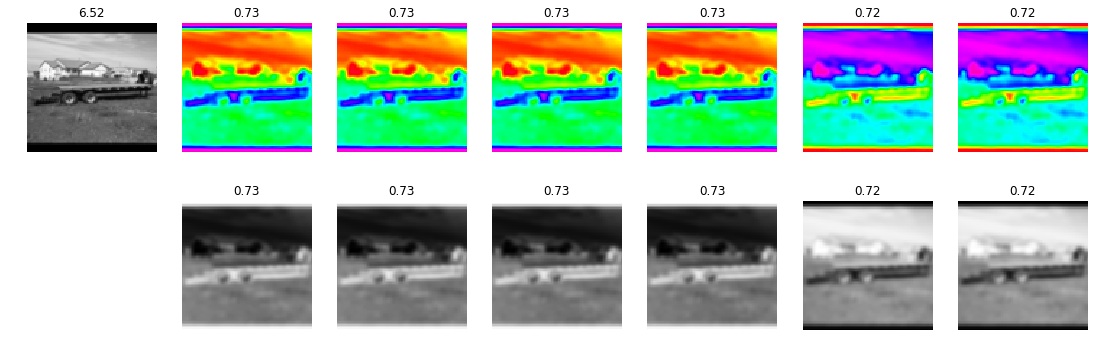

[1, 2, 5, 3, 4, 0]
1


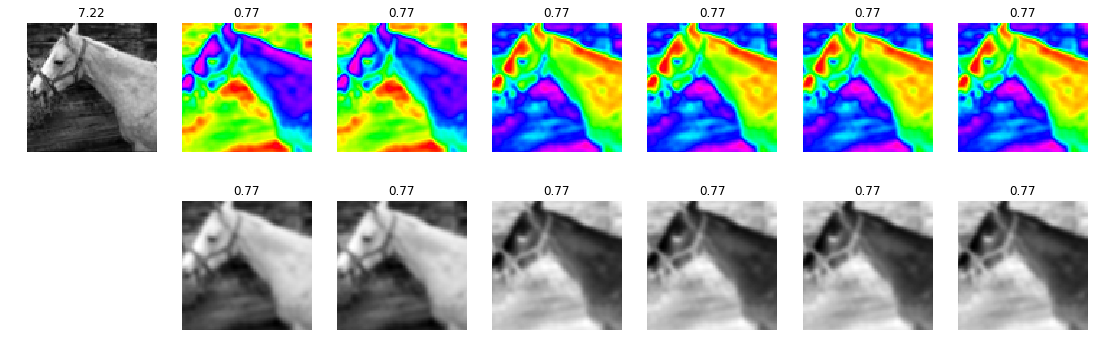

[2, 1, 3, 4, 0, 5]
2


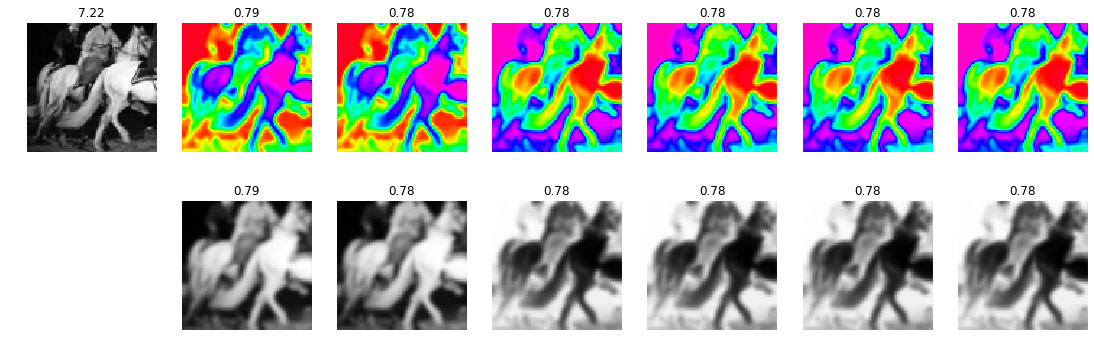

[5, 0, 4, 2, 3, 1]
5


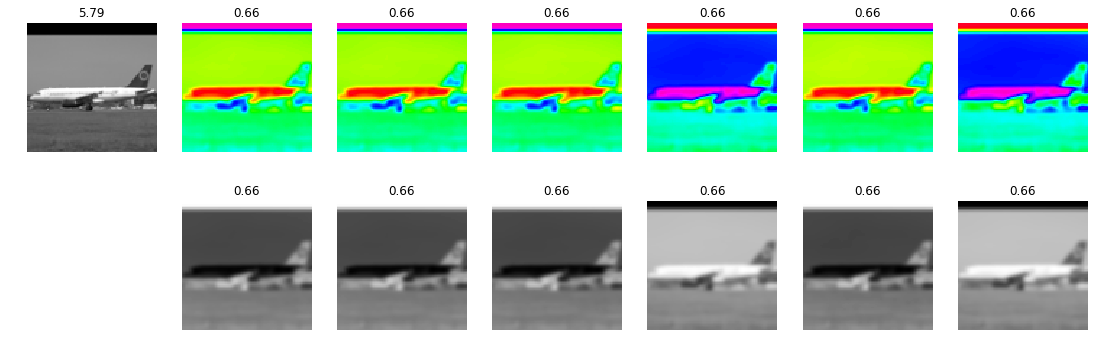

[4, 3, 1, 2, 5, 0]
4


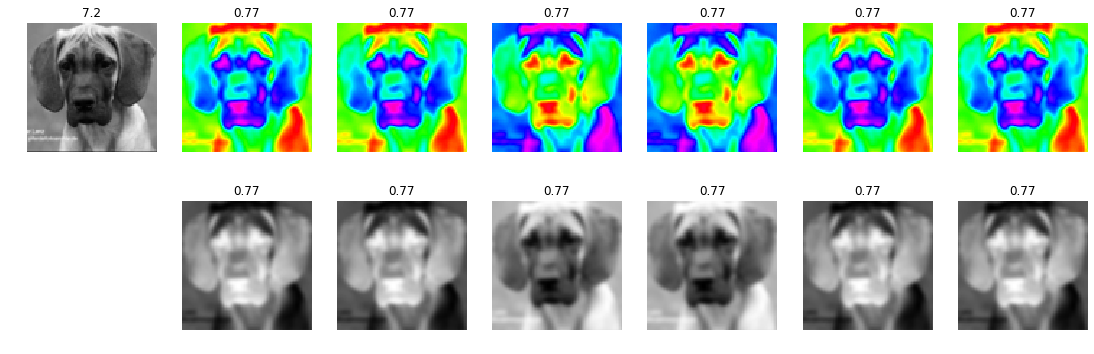

[2, 4, 1, 5, 3, 0]
2


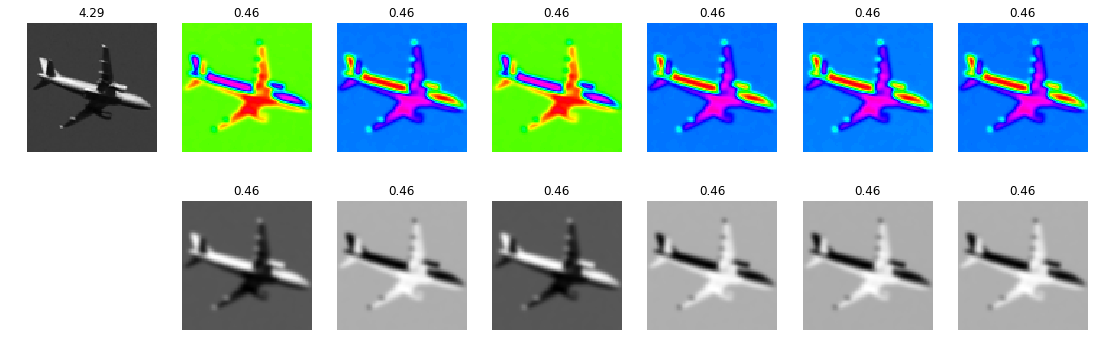

[0, 5, 3, 4, 2, 1]
0


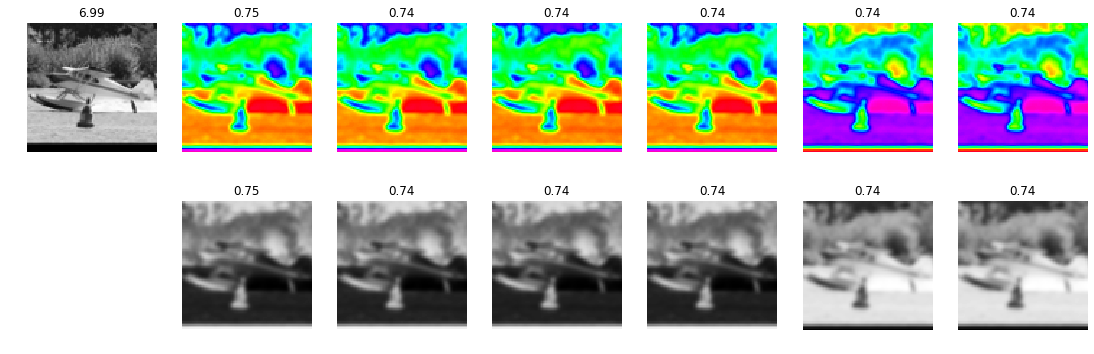

[0, 4, 5, 3, 1, 2]
0


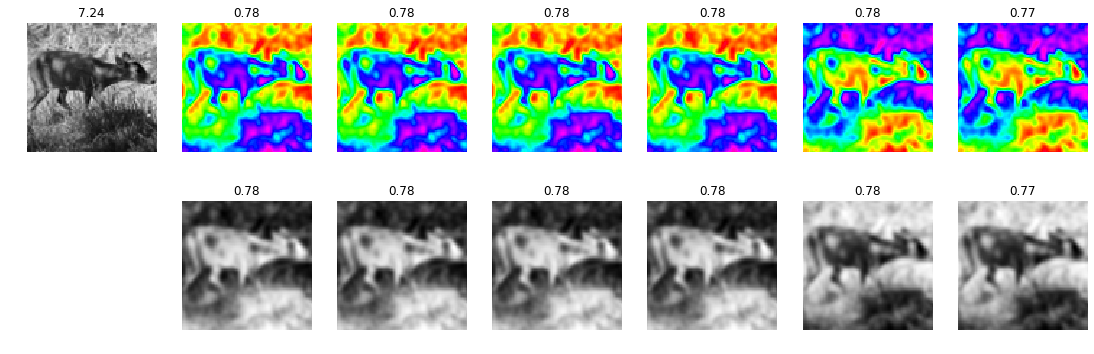

[0, 2, 5, 1, 4, 3]
0


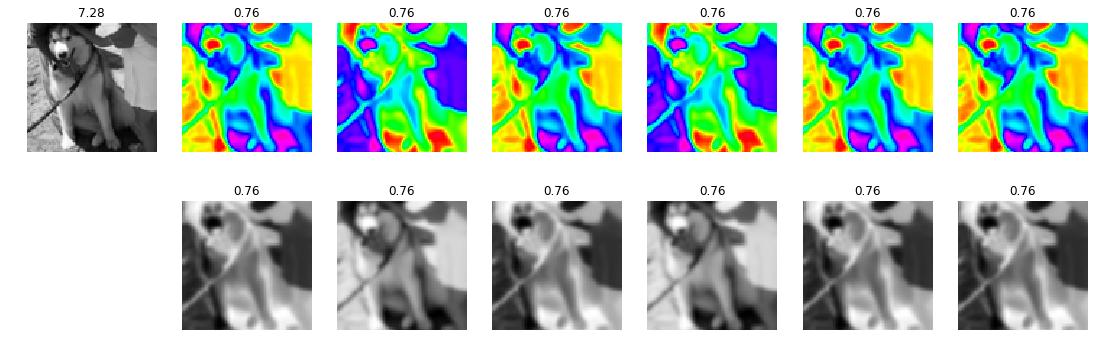

[3, 0, 5, 4, 2, 1]
3


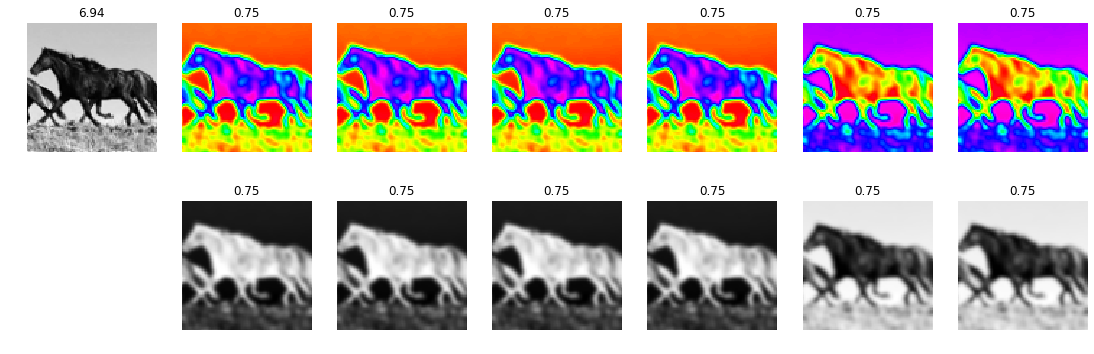

Best :  [0]


In [123]:
# show images
capture_best = []
for current_batch_index in range(0,len(train_images),batch_size):
    current_batch = train_images[current_batch_index:current_batch_index+batch_size]
    
    current_image_resize = np.asarray([resize(np.squeeze(x),(90,90)) for x in current_batch])[:,:,:,None]
    #current_image_resize = (current_image_resize-current_image_resize.min((0,1,2),keepdims=True))/(current_image_resize.max((0,1,2),keepdims=True)-current_image_resize.min((0,1,2),keepdims=True)+1e-8)
    latent_feature = sess.run(final_latent,feed_dict={x_encoding:current_batch})
    #latent_feature = (latent_feature-latent_feature.min((0,1,2),keepdims=True))/(latent_feature.max((0,1,2),keepdims=True)-latent_feature.min((0,1,2),keepdims=True)+1e-8)

    for image_index in range(len(current_batch)-10):
        plt.figure(figsize=(3*num_of_aug+1,6))
        
        plt.subplot(2,num_of_aug+1,1)
        plt.imshow(np.squeeze(current_image_resize[image_index]),cmap='gray')
        upper_bound = calc_MI(current_image_resize[image_index].ravel(),current_image_resize[image_index].ravel())
        plt.title(str(np.around(upper_bound,2)))
        plt.axis('off')
        
        all_image_mi = []
        for image_index2 in range(len(latent_feature.T)): 
            all_image_mi.append(calc_MI(latent_feature[image_index,:,:,image_index2].ravel(),current_image_resize[image_index].ravel()))
        all_image_mi_sort = sorted(range(len(all_image_mi)), key=lambda k: all_image_mi[k])[::-1]
        best_indexn = all_image_mi_sort[0]
        print(all_image_mi_sort)
        print(best_indexn)
        capture_best.append(best_indexn)
        
        count = 2
        for high_index in all_image_mi_sort:
            plt.subplot(2,num_of_aug+1,count)
            plt.imshow(np.squeeze(latent_feature[image_index,:,:,high_index]),cmap='gist_rainbow'); plt.axis('off')
            current_mi= calc_MI(latent_feature[image_index,:,:,high_index].ravel(),current_image_resize[image_index].ravel())
            percent   = 1-(upper_bound-current_mi)/upper_bound
            plt.title(str(np.around(percent,2)))
            count = count + 1
            
        count = count + 1
        for high_index in all_image_mi_sort:
            plt.subplot(2,num_of_aug+1,count)
            plt.imshow(np.squeeze(latent_feature[image_index,:,:,high_index]),cmap='gray'); plt.axis('off')
            current_mi= calc_MI(latent_feature[image_index,:,:,high_index].ravel(),current_image_resize[image_index].ravel())
            percent   = current_mi/upper_bound
            plt.title(str(np.around(percent,2)))
            count = count + 1
            
        plt.show()
    capture_best_index = stats.mode(capture_best)[0]
    print('Best : ',capture_best_index)
    break

In [9]:
# create layers
num_of_aug  = 6
l1_encoder  = CNN(3,1,num_of_aug,           act=tf_relu)
l2_encoder  = CNN(1,  num_of_aug,num_of_aug,act=tf_relu)
l3_encoder  = CNN(3,  num_of_aug,num_of_aug,act=tf_relu)
l4_encoder  = CNN(1,  num_of_aug,num_of_aug,act=tf_relu)
l5_encoder  = CNN(3,  num_of_aug,num_of_aug,act=tf_relu)
l6_encoder  = CNN(1,  num_of_aug,num_of_aug,act=tf_sigmoid)

l1_with_image = CNN(3,num_of_aug*2,num_of_aug*2,act=tf_relu)
l2_with_image = CNN(3,num_of_aug*2,num_of_aug*2,act=tf_relu)
l3_with_image = CNN(3,num_of_aug*2,1,act=tf_iden)

def with_image(input_data):
    _,layer1_g = l1_with_image.feedforward(input_data)
    _,layer2_g = l1_with_image.feedforward(layer1_g)
    _,layer3_g = l1_with_image.feedforward(layer2_g)
    return layer3_g

x_encoding = tf.placeholder(tf.float32,(None,96,96,1))
x_reisze   = tf.image.resize_images(x_encoding,(90,90))
x_reisze   = tf.tile(x_reisze,(1,1,1,num_of_aug))

_,layer1_e = l1_encoder.feedforward(x_encoding)
_,layer2_e = l2_encoder.feedforward(layer1_e)
layer2_e = layer2_e + layer1_e
_,layer3_e = l3_encoder.feedforward(layer2_e)
_,layer4_e = l4_encoder.feedforward(layer3_e)
layer4_e = layer4_e + layer3_e
_,layer5_e = l5_encoder.feedforward(layer4_e)
_,layer6_e = l6_encoder.feedforward(layer5_e)
layer6_e = layer6_e + layer5_e

final_latent  = layer6_e
final_latents = tf.transpose(final_latent,(0,2,1,3))
encoded_gt = tf.concat([final_latent  ,x_reisze],3)
encoded_rd = tf.concat([final_latents ,x_reisze],3)

with_image_gt  = tf.reduce_mean(-tf_tanh(-with_image(encoded_gt)))
with_image_rd  = tf.reduce_mean( tf_tanh( with_image(encoded_rd)))
WITH_IMAGE     = (with_image_rd - with_image_gt) 

LOSS = WITH_IMAGE 
auto_train = tf.train.AdamOptimizer(0.0008).minimize(LOSS)

In [10]:
# train classifier
num_epoch = 200

# read the data
train_images,train_labels,test_images,test_labels = read_STL10_data()
train_images = train_images.mean(3,keepdims=True)
train_images = (train_images-train_images.min((0,1,2),keepdims=True))/(train_images.max((0,1,2),keepdims=True)-train_images.min((0,1,2),keepdims=True)+1e-8)
test_images  = test_images.mean(3,keepdims=True)
test_images  = (test_images-test_images.min((0,1,2),keepdims=True))/(test_images.max((0,1,2),keepdims=True)-test_images.min((0,1,2),keepdims=True)+1e-8)

avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []; dividsion = 1
for iter in range(num_epoch):
    
    # train for training images
    for current_batch_index in range(0,len(train_images),batch_size//dividsion):
        current_batch = train_images[current_batch_index:current_batch_index+batch_size//dividsion]
        current_label = train_labels[current_batch_index:current_batch_index+batch_size//dividsion]
        latent_feature = sess.run(final_latent,feed_dict={x_encoding:current_batch}) 
        latent_feature = np.reshape(np.transpose(latent_feature,(0,3,1,2)),(batch_size//dividsion*num_of_aug,90,90))[:,:,:,None]
        latent_feature = (latent_feature-latent_feature.min((0,1,2),keepdims=True))/(latent_feature.max((0,1,2),keepdims=True)-latent_feature.min((0,1,2),keepdims=True)+1e-8)

        latent_labels  = np.asarray([ [x]* num_of_aug for x in current_label]).reshape((batch_size//dividsion*num_of_aug,10))

        sess_results = sess.run([accuracy,class_train,extra_update_ops],feed_dict={x:latent_feature,y:latent_labels})
        sys.stdout.write(' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]

    # test for training images
    for current_batch_index in range(0,len(test_images),batch_size):
        current_batch  = test_images[current_batch_index:current_batch_index+batch_size]
        current_label  = test_labels[current_batch_index:current_batch_index+batch_size]
        latent_feature = sess.run(final_latent,feed_dict={x_encoding:current_batch})[:,:,:,capture_best_index[0]][:,:,:,None]
        latent_feature = (latent_feature-latent_feature.min((0,1,2),keepdims=True))/(latent_feature.max((0,1,2),keepdims=True)-latent_feature.min((0,1,2),keepdims=True)+1e-8)
       
        sess_results = sess.run([accuracy],feed_dict={x:latent_feature,y:current_label,is_training:False})
        sys.stdout.write(' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0] 
        
    # ======================== print reset ========================
    if iter%1 == 0 :
        train_images,train_labels = shuffle(train_images,train_labels)
        sys.stdout.write("Current : "+ str(iter) + "\t" +
              " Train Acc : " + str(np.around(avg_acc_train/(len(train_images)/batch_size*dividsion),3)) + "\t" +
              " Test Acc : "  + str(np.around(avg_acc_test/(len(test_images)/batch_size),3)) + "\t\n")
        sys.stdout.flush();
    avg_acc_train = 0 ; avg_acc_test  = 0

(5000, 96, 96, 3) 1.0 0.0
(5000, 10) 1.0 0.0
(8000, 96, 96, 3) 1.0 0.0
(8000, 10) 1.0 0.0


FailedPreconditionError: Attempting to use uninitialized value Variable_18
	 [[node Variable_18/read (defined at <ipython-input-2-18ed72b3c9c7>:14)  = Identity[T=DT_FLOAT, _class=["loc:@Variable_18"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](Variable_18)]]
	 [[{{node add_10/_31}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_40_add_10", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Variable_18/read', defined at:
  File "C:\ProgramData\Miniconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Miniconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Miniconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\ProgramData\Miniconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\ProgramData\Miniconda3\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\ProgramData\Miniconda3\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\ProgramData\Miniconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\ProgramData\Miniconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\ProgramData\Miniconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\ProgramData\Miniconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "C:\ProgramData\Miniconda3\lib\site-packages\tornado\gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "C:\ProgramData\Miniconda3\lib\site-packages\tornado\gen.py", line 1080, in __init__
    self.run()
  File "C:\ProgramData\Miniconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\ProgramData\Miniconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\ProgramData\Miniconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\ProgramData\Miniconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Miniconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Miniconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\ProgramData\Miniconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-59e4eb51ae53>", line 3, in <module>
    l1_encoder  = CNN(3,1,num_of_aug,           act=tf_relu)
  File "<ipython-input-2-18ed72b3c9c7>", line 14, in __init__
    self.w              = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 183, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 146, in _variable_v1_call
    aggregation=aggregation)
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 125, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2444, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 187, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 1329, in __init__
    constraint=constraint)
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 1491, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 81, in identity
    return gen_array_ops.identity(input, name=name)
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3454, in identity
    "Identity", input=input, name=name)
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable_18
	 [[node Variable_18/read (defined at <ipython-input-2-18ed72b3c9c7>:14)  = Identity[T=DT_FLOAT, _class=["loc:@Variable_18"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](Variable_18)]]
	 [[{{node add_10/_31}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_40_add_10", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
# len(test_images)
accuray_test = 0
for current_batch_index in range(len(test_images)):
    current_batch = test_images[current_batch_index:current_batch_index+1]
    current_label = test_labels[current_batch_index:current_batch_index+1]
    latent_feature = sess.run(layer2_e,feed_dict={x_encoding:current_batch})
    latent_feature = np.transpose(latent_feature,(3,1,2,0))
    sess_results = sess.run(final_soft,feed_dict={x:latent_feature,y:current_label,is_training:False})
    m = stats.mode(np.argmax(sess_results,1))
    if m[0] == np.argmax(current_label,1):
        accuray_test = accuray_test + 1
print(accuray_test)
print(accuray_test/len(test_images))

In [ ]:
    if avg_acc_test/(len(test_images)/batch_size) < avg_acc_train/(len(train_images)/batch_size*dividsion):
        print('\n MAX  \t')
        for current_batch_index in range(0,len(train_images),batch_size):
            current_batch = train_images[current_batch_index:current_batch_index+batch_size]
            sess_results  = sess.run([TOTAL_LOSS,auto_train],feed_dict={x_encoding:current_batch})
            sys.stdout.write(' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' loss : ' + str(sess_results[0]) + '\r')
            sys.stdout.flush(); 

In [102]:
def soft_absolute(v):
    return np.sqrt(v**2 + 1e-8)

Y = soft_absolute(Y)

# Normalize feature across all examples
# Divide each feature by its l2-norm
Y = Y / np.sqrt(np.sum(Y**2,axis=0) + epsilon)        

# Normalize feature per example
Y = Y / np.sqrt(np.sum(Y**2,axis=1)[:,np.newaxis] + epsilon )



NameError: name 'Y' is not defined

In [111]:
temp = np.around(np.random.randn(10,5),3)
print(temp)
print('------------------------')
Y = soft_absolute(temp)
print(np.around(Y,3))
print('------------------------')
Y = Y / np.sqrt(np.sum(Y**2,axis=0) + 1e-8)  
print(Y.sum(0))
print(np.around(Y,3))
print('------------------------')
Y = Y / np.sqrt(np.sum(Y**2,axis=1)[:,np.newaxis] + 1e-8 )
print(Y.sum(1))
print(np.around(Y,3))
print('------------------------')


[[ 0.707 -0.802  1.314 -0.43  -1.583]
 [ 0.362  1.208 -0.248  1.641 -0.217]
 [-0.625 -0.398  1.882 -0.293 -0.04 ]
 [ 0.692 -0.075  0.475  0.241 -0.025]
 [ 0.801  0.009 -1.272 -0.66   0.114]
 [ 1.082  0.568 -1.558  0.065  1.26 ]
 [ 0.95   0.497  0.015 -1.53  -0.516]
 [-1.128  1.052 -1.303 -0.536 -1.12 ]
 [-0.307  0.911  0.69   0.825 -0.821]
 [ 1.279  1.854  1.135 -0.307  1.92 ]]
------------------------
[[0.707 0.802 1.314 0.43  1.583]
 [0.362 1.208 0.248 1.641 0.217]
 [0.625 0.398 1.882 0.293 0.04 ]
 [0.692 0.075 0.475 0.241 0.025]
 [0.801 0.009 1.272 0.66  0.114]
 [1.082 0.568 1.558 0.065 1.26 ]
 [0.95  0.497 0.015 1.53  0.516]
 [1.128 1.052 1.303 0.536 1.12 ]
 [0.307 0.911 0.69  0.825 0.821]
 [1.279 1.854 1.135 0.307 1.92 ]]
------------------------
[2.95283115 2.57352014 2.73688621 2.49156571 2.40396004]
[[0.263 0.28  0.364 0.164 0.5  ]
 [0.135 0.422 0.069 0.626 0.068]
 [0.233 0.139 0.521 0.112 0.013]
 [0.258 0.026 0.131 0.092 0.008]
 [0.298 0.003 0.352 0.252 0.036]
 [0.403 0.198 0.